In [11]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

In [12]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25
v=0.5

# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

# def phi2(x, y, t):
#     return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)
def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-3+v*t)**2+(y+3-v*t)**2)/(2*sigma1**2))*np.cos(w1*t)

# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 8*np.pi, 1000)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

# data
Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())

np.save("../data/npy/toy1_test",scaled_Phi.T)

data_path = '../data/npy/toy1_test.npy'
model_path = '../model/toy1/'
result_path = '../result/toy1/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [13]:
print(np.shape(scaled_Phi))

(127, 127, 1000)


In [14]:
phi_tot=scaled_Phi.T
new_phi = phi_tot[:500]
print(np.shape(new_phi))
np.random.seed(42)
index=np.random.randint(500,1000,10)
print(index)
phi_test = phi_tot[index]
print(phi_test.shape)
new_phi=tf.expand_dims(new_phi, axis=3)
phi_test=tf.expand_dims(phi_test, axis=3)

(500, 127, 127)
[602 935 848 770 606 571 688 520 602 621]
(10, 127, 127)


In [15]:

y = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),
   padding='same')(new_phi)
#y = tf.keras.layers.Conv2D(2, 3, padding= 'valid',activation='linear', input_shape=(127,127,))(new_phi)
print(tf.shape(y))

tf.Tensor([500  64  64   1], shape=(4,), dtype=int32)


In [16]:

# NN

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=500,
  decay_rate=0.5,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Nadam()


def compile_and_fit(model, name, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError() ,
                metrics=[tf.keras.losses.MeanAbsoluteError()]),
                

    model.summary()

    history = model.fit(
            new_phi, y,
            #steps_per_epoch = STEPS_PER_EPOCH,
            epochs=500,
            validation_split=0.1,
            callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True),
            verbose=2)

    return history



In [17]:


NN1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(64,64,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Reshape((64, 64, 1)),
    # tf.keras.layers.UpSampling2D((2,2)),
    # tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
NN2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(1, 5),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
# inputs      = tf.keras.Input(shape=(3,))
# outputs     = dense(inputs)
# Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

inputs      = tf.keras.Input(shape=(127,127,1))
#outputs     = inputs[:,0:3] + 0.01*dense(inputs)
#upscaling davanti a NN1
outputs     = NN1(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(inputs)) #+ NN2(inputs)
Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

history = compile_and_fit(Updatemodel, 'Lorentz')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127, 127, 1)]     0         
                                                                 
 average_pooling2d_1 (Averag  (None, 64, 64, 1)        0         
 ePooling2D)                                                     
                                                                 
 sequential (Sequential)     (None, 64, 64, 1)         2400      
                                                                 
Total params: 2,400
Trainable params: 2,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
15/15 - 3s - loss: 0.2313 - mean_absolute_error: 0.4336 - val_loss: 0.3679 - val_mean_absolute_error: 0.5659 - 3s/epoch - 177ms/step
Epoch 2/500
15/15 - 0s - loss: 0.1795 - mean_absolute_error: 0.3721 - val_loss: 0.2833 - val_mean_absolute_error

In [18]:
test_true = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),
   padding='same')(phi_test)
test_model = history.model.predict(phi_test)

1/1 [==============================] - 0s 195ms/step


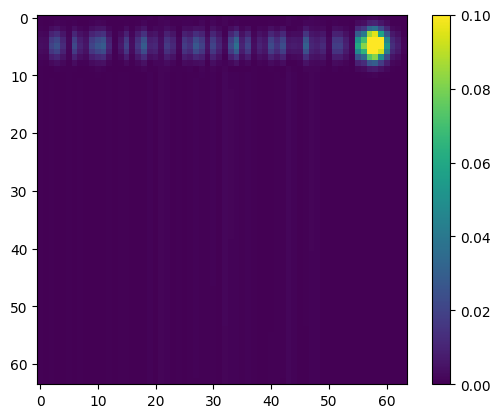

In [19]:
plt.imshow(np.abs(test_true[5]-test_model[5]),vmax=0.1)
plt.colorbar()

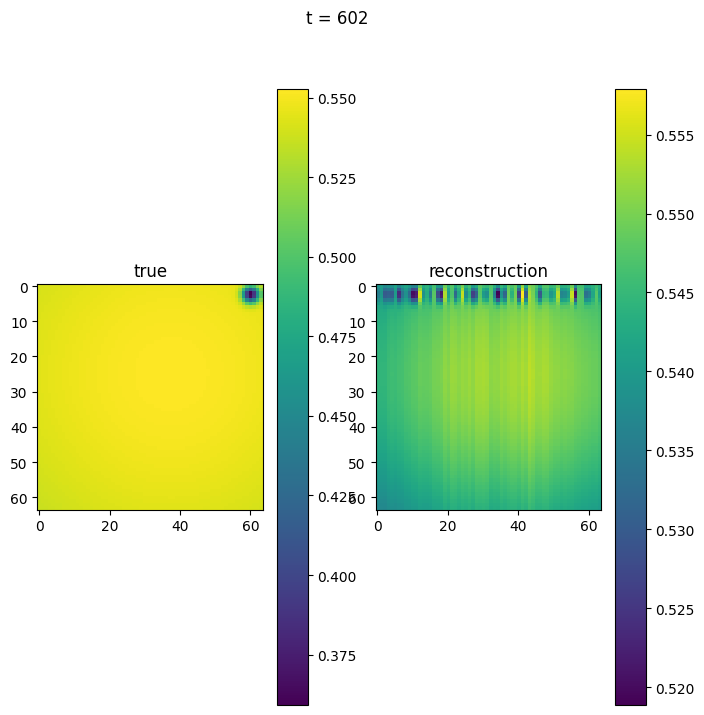

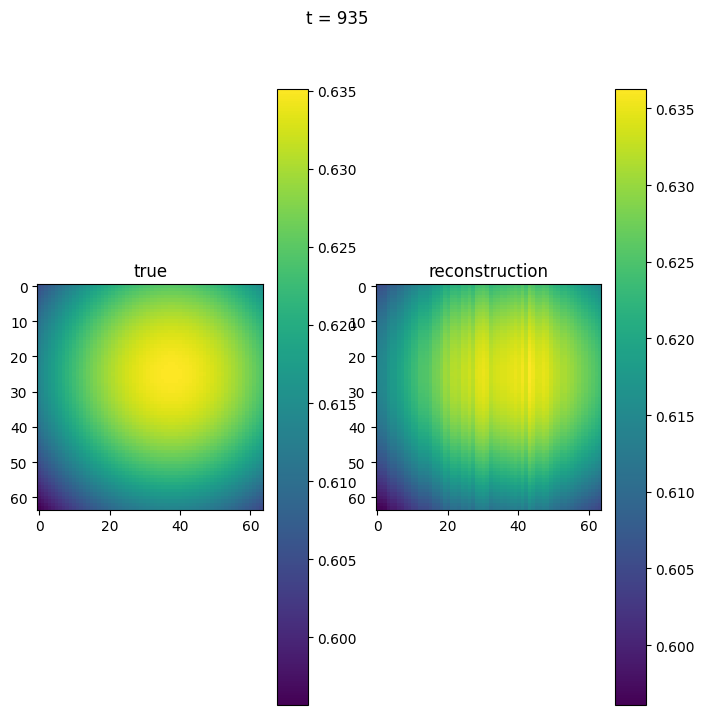

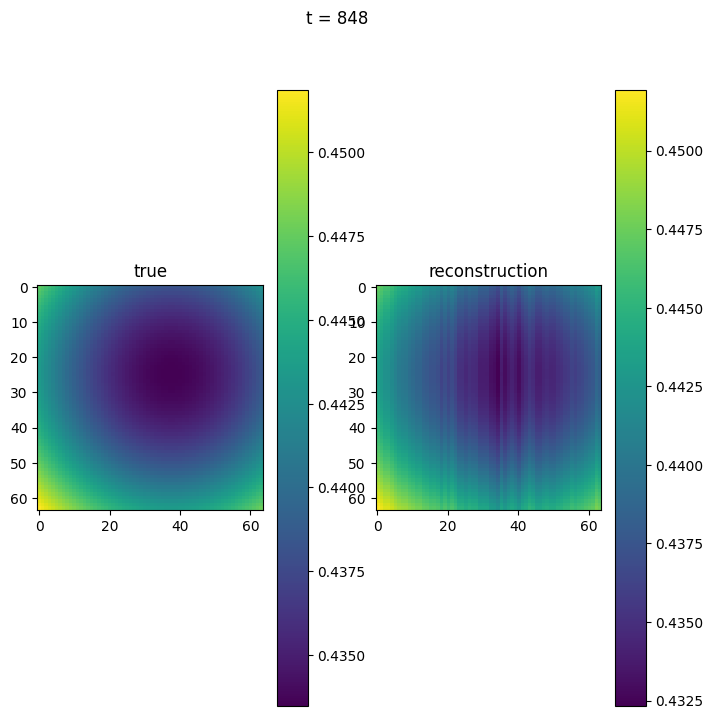

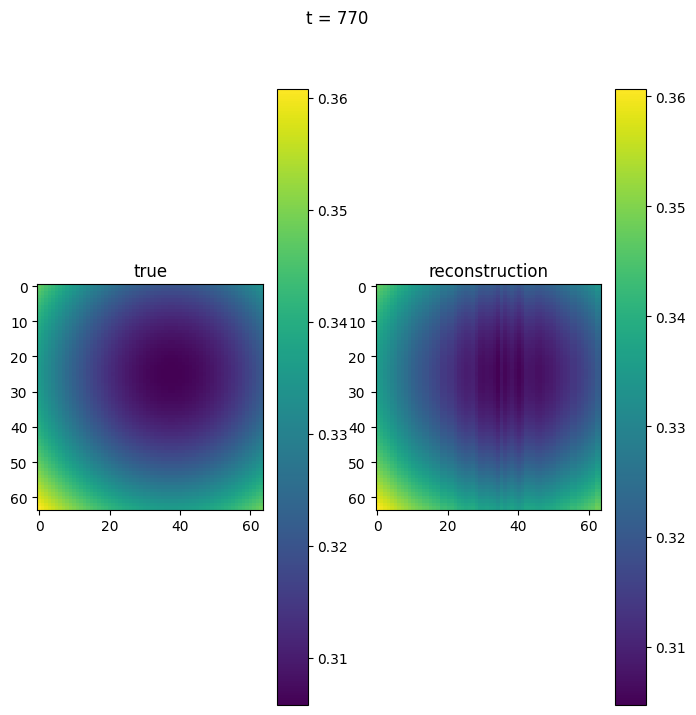

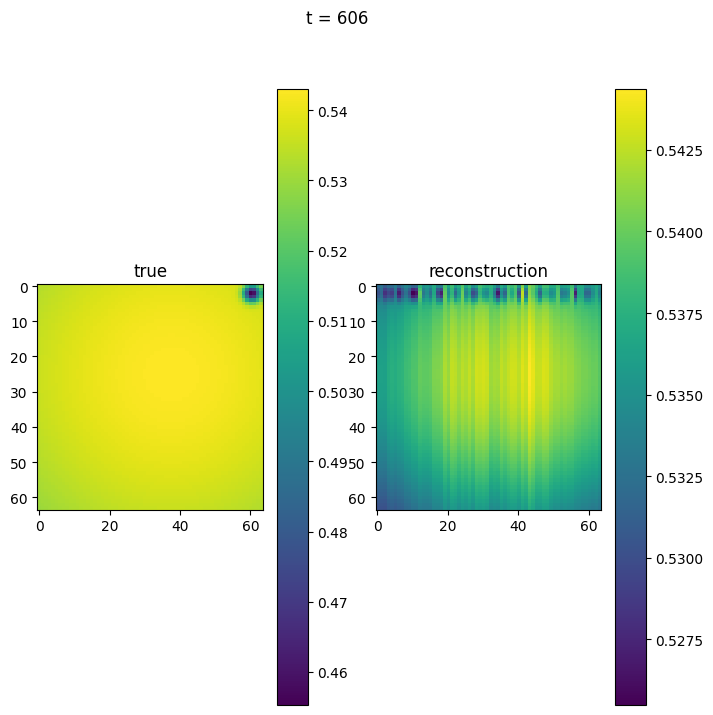

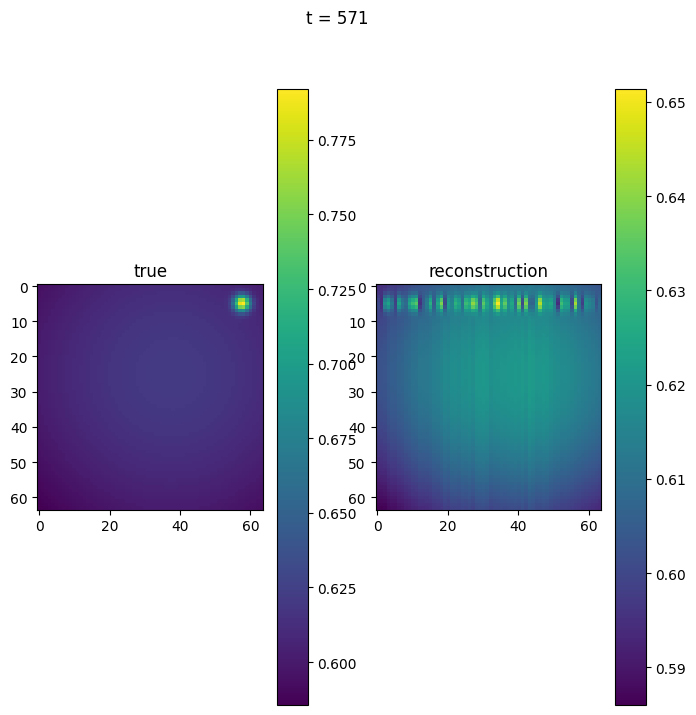

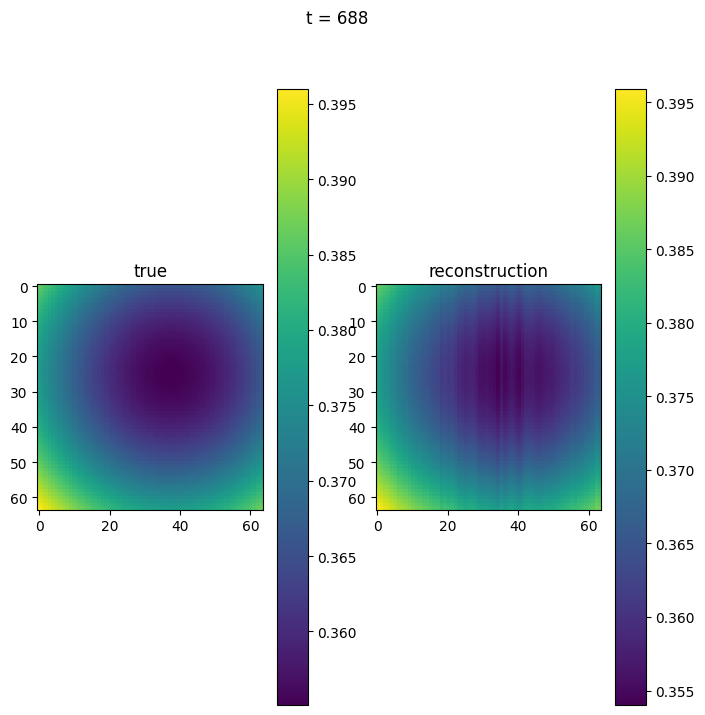

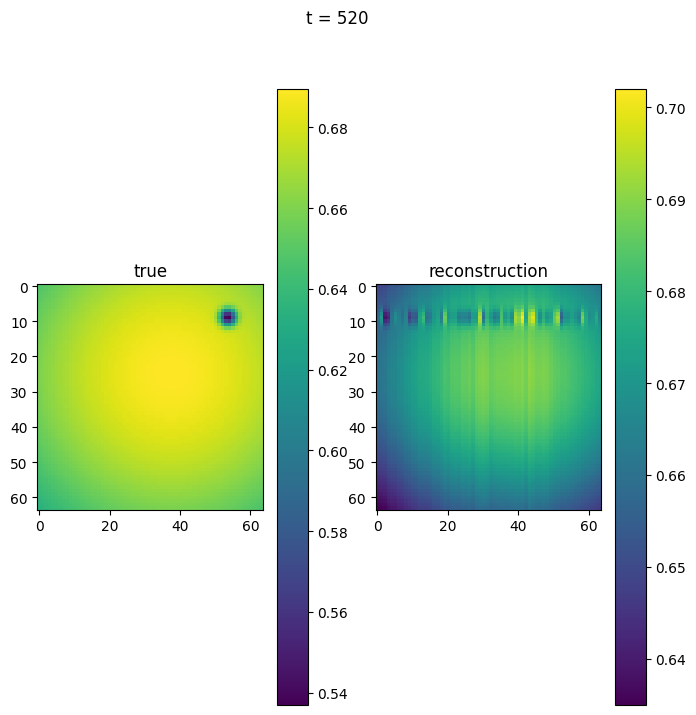

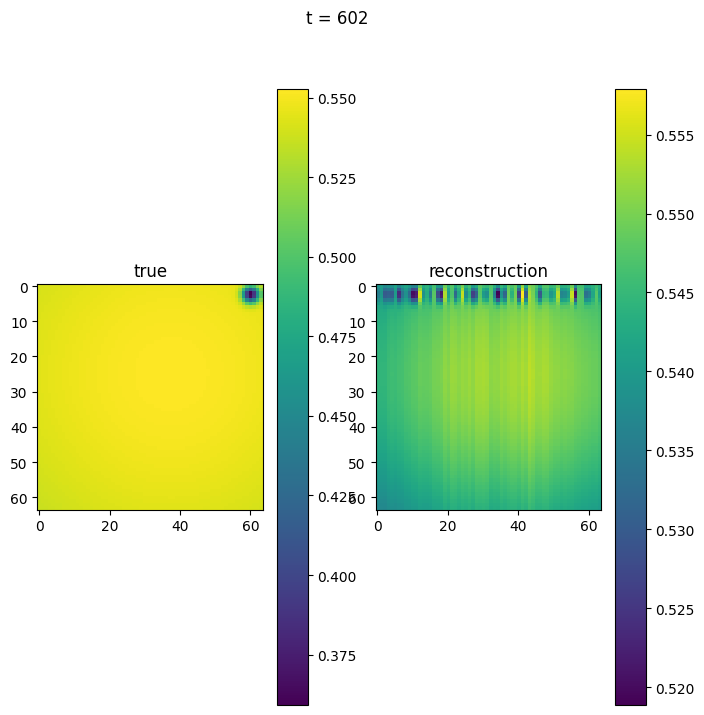

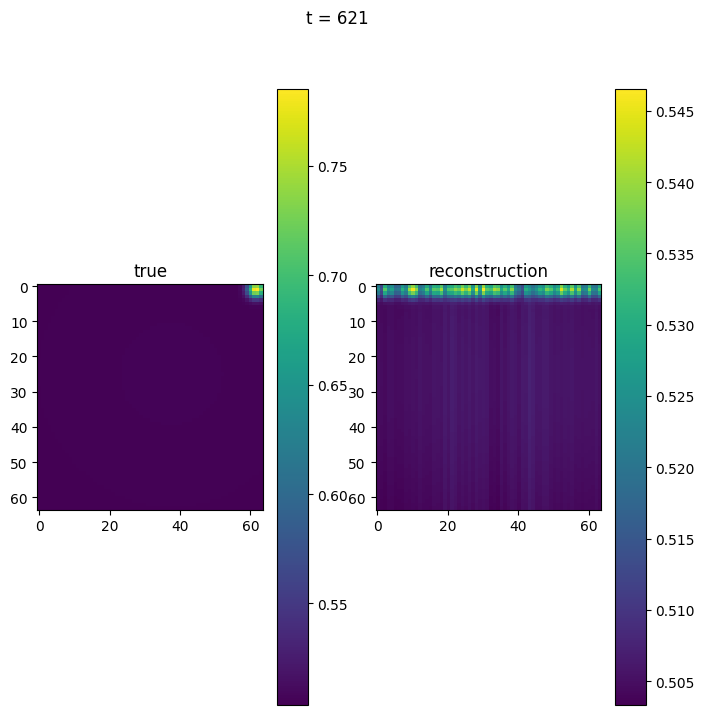

In [28]:
for ind in range(10):
    fig,axs = plt.subplots(1,2,figsize=(8,8))
    im = axs[0].imshow(test_true[ind])
    axs[0].set_title('true')
    plt.colorbar(im, ax=axs[0])
    im = axs[1].imshow(test_model[ind])
    axs[1].set_title('reconstruction')
    plt.colorbar(im, ax=axs[1])
    fig.suptitle('t = ' +str(index[ind]))



In [21]:
print(test_model[-1])

[[[0.5214351 ]
  [0.5124051 ]
  [0.5302317 ]
  ...
  [0.5205862 ]
  [0.52001584]
  [0.52934223]]

 [[0.5246768 ]
  [0.5139902 ]
  [0.53520423]
  ...
  [0.52358437]
  [0.5228316 ]
  [0.5340088 ]]

 [[0.5206914 ]
  [0.5120862 ]
  [0.52904576]
  ...
  [0.51991373]
  [0.5193892 ]
  [0.5282414 ]]

 ...

 [[0.50385374]
  [0.5036551 ]
  [0.50341785]
  ...
  [0.50427336]
  [0.50467885]
  [0.50413656]]

 [[0.5038032 ]
  [0.5036042 ]
  [0.5033668 ]
  ...
  [0.5042177 ]
  [0.50462365]
  [0.5040815 ]]

 [[0.5037649 ]
  [0.5035656 ]
  [0.5033281 ]
  ...
  [0.5041754 ]
  [0.50458187]
  [0.50403976]]]
